<a href="https://colab.research.google.com/github/dnguyend/regularMTW/blob/main/colab/HyperbolicDualGraphAndDivergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workbook illustrating hyperbolic duality and divergence.

First, download the library

In [1]:
!git clone https://github.com/dnguyend/regularMTW.git


Cloning into 'regularMTW'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 56 (delta 21), reused 26 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 76.94 KiB | 1.22 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jla
import matplotlib.pyplot as plt
from jax import jvp, jacfwd, jacrev, random, grad
import regularMTW.src.hyperbolic_potential as hypo
from regularMTW.src.tools import asym, sym2, sym, Lyapunov, vcat
from regularMTW.src.simple_mtw import (
    GenHyperbolicSimpleMTW,
    LambertSimpleMTW,
    TrigSimpleMTW,
    GHPatterns, LambertPatterns,
    basePotential, grand, splitzero)
from regularMTW.src.tools import (vcat)

jax.config.update("jax_enable_x64", True)

$\newcommand{\bcc}{\bar{c}}$
$\newcommand{\bx}{\bar{x}}$
$\newcommand{\arcsinh}{\mathsf{arcsinh}}$
Warm up: A quick graph showing the duals using the cost $-\frac{1}{r}\arcsinh(x^T\bx)$ converges to the Legendre dual.

The graph is for $x^{\frac{1}{8}}$ and can be changed. Also, not graphed here. a simple formula for the case $\phi(x) = |x|^2$ shows $\lim_{r\to 0}\phi^{\bcc}(\bx)= \frac{1}{4}|\bx|^2$.
$$\phi^{\bcc}(\bx) = \frac{\log((1+|\bx|^4r^2)^{\frac{1}{2}} + r|\bx|^2)}{2r} \
        - \frac{1}{2}\frac{|\bx|^2}{(1 + (1 + r^2|\bx|^4)^{\frac{1}{2}})}.
$$

Text(0.5, 0, '$\\bar{x}$')

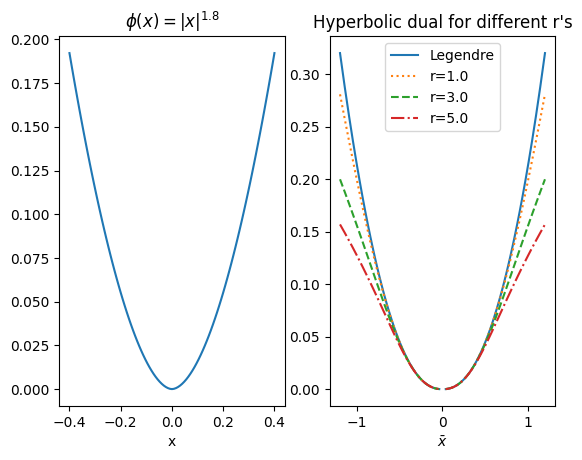

In [3]:
pw = 1.8
n = 1
n_pts = 50
Mx = .4
X = Mx*jnp.arange(2*n_pts+1)/n_pts - Mx



fig, axes = plt.subplots(1, 2)
r2 = 2.
plpw2 = hypo.PtPow(
    pw,
    GenHyperbolicSimpleMTW(n, jnp.eye(n), jnp.array([.5/r2, -r2, -.5/r2, r2]), None))

phi_grid = jnp.array([plpw2.fphi(x) for x in X])

axes[0].plot(X, phi_grid)

Yr2 = jnp.array([plpw2.OptMap(x, plpw2.mtw) for x in X])
phic_legendre = pw**(-pw/(pw-1))*(pw - 1)*(jnp.abs(Yr2))**(pw/(pw-1))

axes[1].plot(Yr2, phic_legendre, label='Legendre', linestyle='solid')

def make_one_curve(Yr, r):

  GH = GenHyperbolicSimpleMTW(n, jnp.eye(n), jnp.array([.5/r, -r, -.5/r, r]), None)
  plpw = hypo.PtPow(pw, GH)
  plpwd = hypo.PtPowerDual(plpw)
  # Yr = jnp.array([plpwd.OptMap(x, plpwd.mtw) for x in Xr])
  phic_grid = []
  for idx in jnp.arange(Yr.shape[0]):
      try:
          # val = - plpwd._Lfunc(Xr[idx], Yr[idx])
          val = plpwd.fphi(Yr[idx])
      except Exception:
          val = jnp.nan
      phic_grid.append(val)
  return phic_grid
styles = ['dotted', 'dashed', 'dashdot']
r_list = [1., 3., 5.]
for ri in range(len(r_list)):
  r = r_list[ri]
  phicg = make_one_curve(Yr2, r)
  axes[1].plot(Yr2, phicg, label=f'r={r}', linestyle=styles[ri])

axes[1].legend()
axes[0].set_title(f'$\\phi(x)=|x|^{{{pw}}}$')
axes[0].set_xlabel('x')
axes[1].set_title("Hyperbolic dual for different r's")
axes[1].set_xlabel('$\\bar{x}$')


Another type of graph covering the defining range of the optimal map for different $r$s, which is $(rp)^{-\frac{1}{p}}$. For $p$ closes to $1$, the graph is near flat near $0$, which causes the optimizer to fail, giving a small gap in the middle. This is the picture we see when we treated the case $p=1$.

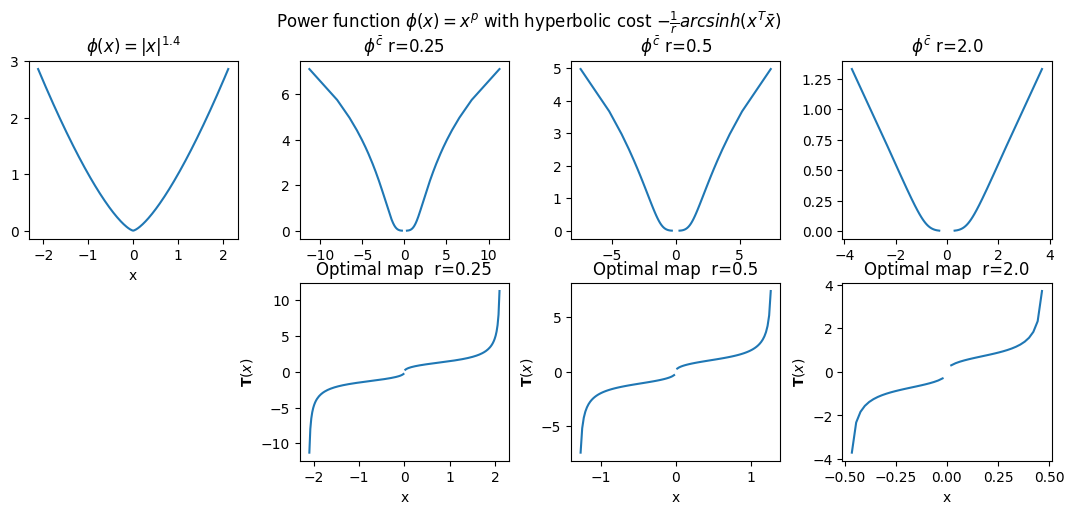

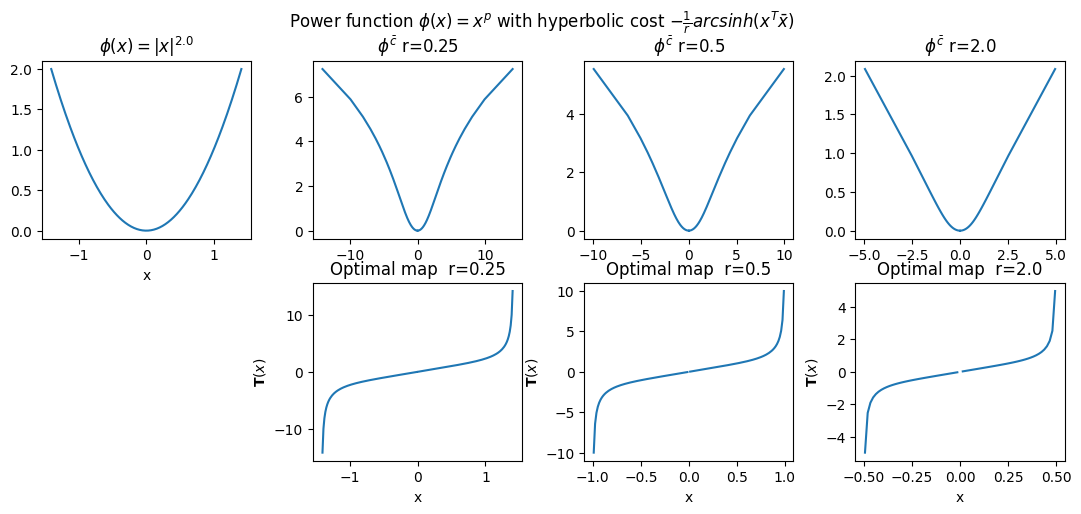

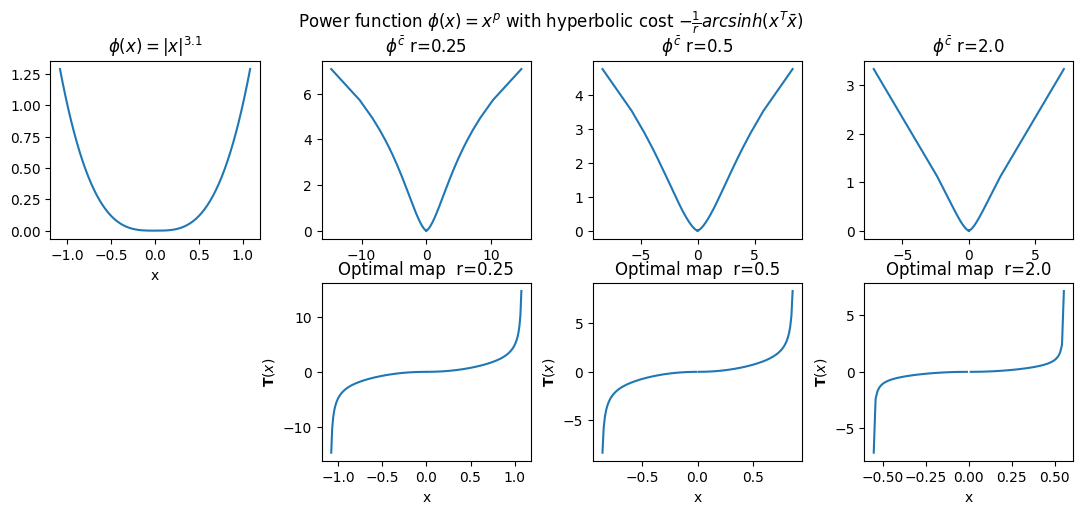

In [4]:
n = 1

r_arr = jnp.array([.25, .5, 2])
pw_arr = jnp.array([1.4, 2., 3.1])
GH_arr = []
pt_arr = []

def make_ptls(GH_ar, pw):
    return [hypo.PtPow(pw, GH) for GH in GH_ar]

def make_ptds(PtPws):
    return [hypo.PtPowerDual(ptl) for ptl in PtPws]

for i in range(len(r_arr)):
    r = r_arr[i]
    GH_arr.append(GenHyperbolicSimpleMTW(
        n, jnp.eye(n), jnp.array([.5/r, -r, -.5/r, r]), None))

for pw in pw_arr:
    pt_arr.append(
        {'ptl': make_ptls(GH_arr, pw)})

for i in range(len(pt_arr)):
    pt_arr[i]['ptd'] = make_ptds(pt_arr[i]['ptl'])

for p_idx in range(pw_arr.shape[0]):
    fig, axes = plt.subplots(2, 4, figsize=(11, 5))
    fig.suptitle("Power function $\\phi(x)=x^p$ with hyperbolic cost $-\\frac{1}{r}arcsinh(x^T\\bar{x})$  ")
    fig.tight_layout()
    pw = pw_arr[p_idx]
    n_grid = 100
    M = jnp.max(1/(pw*r_arr)**(1/pw))
    X = M*jnp.arange(2*n_grid+1)/n_grid - M
    phi_grid = jnp.array([pt_arr[p_idx]['ptl'][0].fphi(x) for x in X])
    axes[0, 0].plot(X, phi_grid)
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_title(f"$\\phi(x) = |x|^{{{pw}}}$")
    axes[1, 0].axis('off')

    for r_idx in range(r_arr.shape[0]):
        Xr = X[jnp.abs(X) < 1/(pw*r_arr[r_idx])**(1/pw)]
        Yr = jnp.array([pt_arr[p_idx]['ptl'][r_idx].OptMap(
            x, pt_arr[p_idx]['ptl'][r_idx].mtw) for x in Xr])
        axes[1, r_idx+1].plot(Xr, Yr)
        axes[1, r_idx+1].set_title(f"Optimal map  r={r_arr[r_idx]}")
        axes[1, r_idx+1].set_xlabel('x')
        axes[1, r_idx+1].set_ylabel('$\\mathbf{T}(x)$')
        phic_grid = []
        for idx in jnp.arange(Xr.shape[0]):
            try:
                val = -pt_arr[p_idx]['ptd'][0]._Lfunc(Xr[idx], Yr[idx])
            except Exception:
                val = jnp.nan
            phic_grid.append(val)

        axes[0, r_idx+1].plot(Yr, phic_grid)
        axes[0, r_idx+1].set_title("$\\phi^{\\bar{c}}$" + f" r={r_arr[r_idx]}")

    plt.show()


$\newcommand{\barD}{\bar{D}}$
$\newcommand{\cD}{\mathcal{D}}$
$\newcommand{\bcD}{\bar{\mathcal{D}}}$
# Check the Amari-Chentsov tensor
It is
$\xi_3^T hess^c_{\phi}(x)(\Gamma^{-1}(\xi_1, \xi_2) - \Gamma^1(\xi_1, \xi_2))$, which is a straighforward term collection. We implemet it in PtHyperbolic as shown here

```def AmariChentsov(self, x, xix1, xix2, xix3):
        r = self.mtw.p[-1]
        hphi = self.hessphi
        t3phi = self.D3phi

        g = self.gradphi(x)
        xg = x.dot(g)

        return t3phi(x, xix2, xix1).dot(xix3) \
            + r**2*(
                + 2*xg*g.dot(xix1)*hphi(x, xix2).dot(xix3)
                + 2*xg*g.dot(xix2)*hphi(x, xix1).dot(xix3)
                + 2*g.dot(xix3)*xix2.dot(hphi(x, xix1))*xg
                + (1+6*r**2*xg**2)*g.dot(xix3)*xix1.dot(g)*xix2.dot(g)
                + g.dot(xix3)*xix2.dot(g)*x.dot(hphi(x, xix1))
                + g.dot(xix1)*g.dot(xix2)*hphi(x, x).dot(xix3)
                + g.dot(xix3)*xix1.dot(g)*x.dot(hphi(x, xix2))
```
We now test it below


In [5]:
key = random.PRNGKey(0)

r = 1.4
pp1 = jnp.array([0.5/r, -r, -0.5/r, r])
pw = 3.1
n = 3
GH1 = GenHyperbolicSimpleMTW(n, jnp.eye(n), pp1, None)

q, key = grand(key, (2*n,))
Omg1, key = grand(key, (2*n,))
Omg2, key = grand(key, (2*n,))
Omg3, key = grand(key, (2*n,))

xi1, key = grand(key, (n,))
xi2, key = grand(key, (n,))
xi3, key = grand(key, (n,))

ptl1 = hypo.PtPow(pw, GH1)

xe = q[:n]/(1+pw**2*ptl1.fphi(q[:n]))**(1/pw)

Gd = ptl1.GammaDivDualistic(xe, xi1, xi2)
print(ptl1.diag_metric(xe,  xi3).dot(Gd[n:] - Gd[:n]))
print(ptl1.AmariChentsov(xe, xi1, xi2, xi3))


-17.776364161486207
-17.776364161486207


# Check the Primal Divergence connection

This is also straightforward using the formula
$$R_{\xi_1\xi_2}\xi_3 = D_{\xi_1}\Gamma^1(x, \xi_2, \xi_3) - D_{\xi_2}\Gamma^1(\xi_1, \xi_3)
+ \Gamma_1(x, \xi_1, \Gamma^1(x, \xi2, \xi_3)) - \Gamma_1(x, \xi_2, \Gamma^1(x, \xi1, \xi_3))
$$
The formula is implemted below
```
def Curv13(self, x, xi1, xi2, xi3):
        """ Curvature of the primal connection
        """
        r = self.mtw.p[-1]

        g = self.gradphi(x)
        hh = self.hessphi
        xg = x.dot(g)
        ret = - r**2*g.dot(xi2)*hh(x, xi1).dot(xi3)*x\
            + r**2*g.dot(xi1)*hh(x, xi2).dot(xi3)*x\
            \
            + r**2*x.dot(hh(x, xi2))*g.dot(xi3)*xi1 \
            + r**2*x.dot(g)*hh(x, xi2).dot(xi3)*xi1 \
            + 2*r**4*xg**2*g.dot(xi2)*g.dot(xi3)*xi1 \
            \
            - r**2*x.dot(hh(x, xi1))*g.dot(xi3)*xi2 \
            - r**2*x.dot(g)*hh(x, xi1).dot(xi3)*xi2 \
            - 2*r**4*xg**2*g.dot(xi1)*g.dot(xi3)*xi2 \
            \
            - r**2*x.dot(hh(x, xi1))*g.dot(xi2)*xi3 \
            + r**2*x.dot(hh(x, xi2))*g.dot(xi1)*xi3 \

        return ret
```
We verify it numerically here

In [6]:
def CurvNumeric(self, x, xi1, xi2, xi3):
  D1 = jvp(lambda x: self.GammaDiv1(x, xi2, xi3), (x,), (xi1,))[1]
  D2 = jvp(lambda x: self.GammaDiv1(x, xi1, xi3), (x,), (xi2,))[1]
  G1 = self.GammaDiv1(x, xi1, self.GammaDiv1(x, xi2, xi3))
  G2 = self.GammaDiv1(x, xi2, self.GammaDiv1(x, xi1, xi3))
  return D1 - D2 + G1 - G2

xi1, key = grand(key, (n,))
xi2, key = grand(key, (n,))
xi3, key = grand(key, (n,))


print(CurvNumeric(ptl1, xe, xi1, xi2, xi3))
print(ptl1.Curv13(xe, xi1, xi2, xi3))


[-0.06427799  1.60294284 -6.76933902]
[-0.06427799  1.60294284 -6.76933902]


# TEST DIVERGENCE.

In [7]:
import numpy as np

def gen_prob(n):
  w = np.random.randn(n)
  return np.abs(w)/np.abs(w).sum()

def gen_opaque(w, repw, n_samples=1):
    """ Generate Random sample with opaque set, which is the set of the first
    n0 samples.
    Generating a random choice between 0 and n-1, with weigh w
    if the choice is between 0 and n0, return a random choice between 0 and n0
    with weight repw.
    Thus, we do not view the true weight, only an opaque weight masked by the replacement.
    """
    n = w.shape[0]
    n0 = repw.shape[0]
    tmp = np.random.choice(n, n_samples, p=w)
    rpl = np.where(tmp < n0)[0]
    if rpl.shape[0] > 0:
        tmp[rpl] = np.random.choice(n0, rpl.shape[0], p=repw)
    return tmp

def alpha_raw(al, prob0, prob1):
  """ The alpha divergence, without the factor al(al-1)
  """
  return -np.log(np.sum(prob0**al*prob1**(1-al)))

def alpha_blank(al, n0, prob0, prob1):
  """ The alpha divergence, but treating the opaque set as one event.
   Without the factor al(al-1)
  """
  return -np.log(np.sum(prob0[n0:]**al*prob1[n0:]**(1-al))
                    + prob0[:n0].sum()**al*prob1[:n0].sum()**(1-al)
                    )

def alpha_hyper(al, n0, prob0, prob1):
  """ The hyperbolic alpha divergence, as in the paper
   without the factor al(al-1)
  """
  ing = np.sum(prob0[n0:]**al*prob1[n0:]**(1-al))
  mu01 = prob0[n0:].sum()
  mu11 = prob1[n0:].sum()
  return al*(mu01 - mu11) - np.log((ing + (ing**2 + 1 - mu11**2)**.5)/(1+mu11))


def alpha_fdiv(al, n0, prob0, prob1):
  """ Another local divergence based on the f divergence.
  """
  mu01 = prob0[n0:].sum()
  mu11 = prob1[n0:].sum()

  ing = np.sum(prob0[n0:]**al*prob1[n0:]**(1-al))
  # return  (1-al)*mu11 + mu01**al - (1-al) - ing
  return al*np.log(mu01) + (1-al)*np.log(mu11) - np.log(ing)





First test - show how we use gen_opaque  to generate two density identical outside of a set $\Omega_0 = \{0,\cdots, n_0-1\}$. We put two different replacement  measures, $repw0$ is the uniform measure and $repw1$ has weight $\{1,2,\cdots n\}$.

In [8]:
n = 10
n0 = 3
n1 = n - n0
w = np.abs(np.random.randn(n))
w = w/w.sum()
repw0 = 1/n0*np.ones(n0)
repw1 = 2./(n0*(n0+1))*np.arange(1, n0+1)

ret0 = gen_opaque(w, repw0, n_samples=100000)
ret1 = gen_opaque(w, repw1, n_samples=100000)

for i in np.arange(n):
    print(i, np.where(ret0 == i)[0].shape[0]/ret0.shape[0],
          np.where(ret1 == i)[0].shape[0]/ret0.shape[0])



0 0.16927 0.08558
1 0.17352 0.17231
2 0.1717 0.26076
3 0.132 0.12914
4 0.00592 0.00598
5 0.03403 0.03363
6 0.09113 0.08984
7 0.04438 0.04401
8 0.12787 0.12742
9 0.05018 0.05133


In [9]:
def test_al_local_disc(n, al, n0, ntest):
    """ compare two measures with
    """
    # weigh
    prob0 = np.zeros(n)
    prob1 = np.zeros(n)

    all_raw = np.zeros(ntest)
    all_blk = np.zeros(ntest)
    all_hyper = np.zeros(ntest)
    all_fdiv = np.zeros(ntest)
    repw0 = gen_prob(n0)
    repw1 = gen_prob(n0)

    for j in range(ntest):
        w1 = np.abs(np.random.randn(n))
        w1 = w1/w1.sum()

        ret0 = gen_opaque(w, repw0, n_samples=100000)
        ret1 = gen_opaque(w1, repw1, n_samples=100000)
        prob0 = np.zeros(n)
        prob1 = np.zeros(n)
        for i in np.arange(n):
            prob0[i] = np.where(ret0 == i)[0].shape[0]/ret0.shape[0]
            prob1[i] = np.where(ret1 == i)[0].shape[0]/ret0.shape[0]

        raw = alpha_raw(al, prob0, prob1)
        blk = alpha_blank(al, n0, prob0, prob1)
        hyper = alpha_hyper(al, n0, prob0, prob1)
        fdiv = alpha_fdiv(al, n0, prob0, prob1)
        all_raw[j] = raw
        all_blk[j] = blk
        all_hyper[j] = hyper
        all_fdiv[j] = fdiv

        if hyper > blk:
            print(f"found {j}")
            break
        if raw < hyper:
            print(f"bad {j}")
            break
    return all_raw, all_blk, all_hyper, all_fdiv



Numerically, without a proof, the local hyperbolic is always smaller than the simple blank out. It is also smaller than the local f-divergence version.

0.12383667078840725 0.12808716657479965
0.01780738180281194 -1.928580006027699


Text(0.5, 1.0, 'Hyperbolic versus local f divergence')

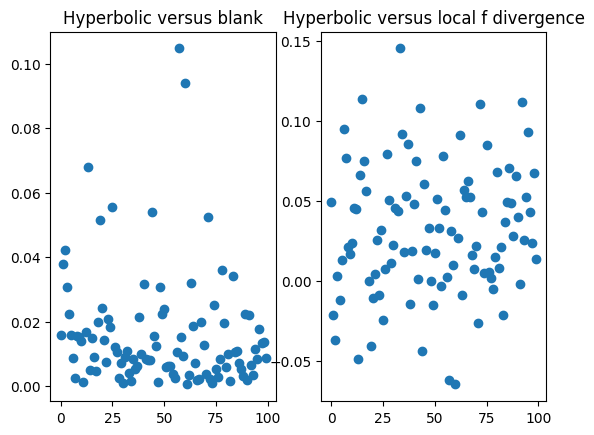

In [10]:
all_raw, all_blk, all_hyper, all_fdiv = test_al_local_disc(n=10, al=.4, n0=3, ntest=100)
# print(np.min(all_blk - all_hyper))
print(np.mean(1-all_hyper/all_blk), np.mean(1-all_hyper/all_fdiv))
print(np.min(1-all_hyper/all_blk), np.min(1-all_hyper/all_fdiv))
fig, axs = plt.subplots(1, 2)
axs[0].scatter(np.arange(all_blk.shape[0]), all_blk- all_hyper)
axs[1].scatter(np.arange(all_blk.shape[0]), all_fdiv- all_hyper)
axs[0].set_title("Hyperbolic versus blank")
axs[1].set_title("Hyperbolic versus local f divergence")
# plt.scatter(np.arange(all_hyper.shape[0]), all_hyper)

A bigger test, $10^3$ batch of the first test

In [12]:
np.random.seed(0)
n_batch = int(1e3)
bsize = 100
ret_mean = np.zeros((2, n_batch))
ret_min = np.zeros((2, n_batch))
bad_size = np.zeros(n_batch)
for i in range(n_batch):
  all_raw, all_blk, all_hyper, all_fdiv = test_al_local_disc(n=10, al=.4, n0=3, ntest=bsize)
  ret_mean[:, i] = np.mean(1-all_hyper/all_blk), np.mean(1-all_hyper/all_fdiv)
  ret_min[:, i] = np.min(1-all_hyper/all_blk), np.min(1-all_hyper/all_fdiv)
  bad_size[i] = np.where(all_hyper > all_fdiv)[0].shape[0] / bsize
  if i % 100 == 0:
    print(f"Doing i={i}")


Doing i=0
Doing i=100
Doing i=200
Doing i=300
Doing i=400
Doing i=500
Doing i=600
Doing i=700
Doing i=800
Doing i=900


Summarizing the results

In [13]:
print(ret_mean.min(axis=1))
print(ret_min.min(axis=1))
print(bad_size.mean())


[ 0.08544204 -0.00391611]
[ 1.31855820e-03 -1.34358276e+01]
0.18004000000000003


0.17693290394299466 0.6514025168741217
0.1642420356152734 0.468862047326674


Text(0.5, 1.0, 'Hyperbolic versus local f divergence')

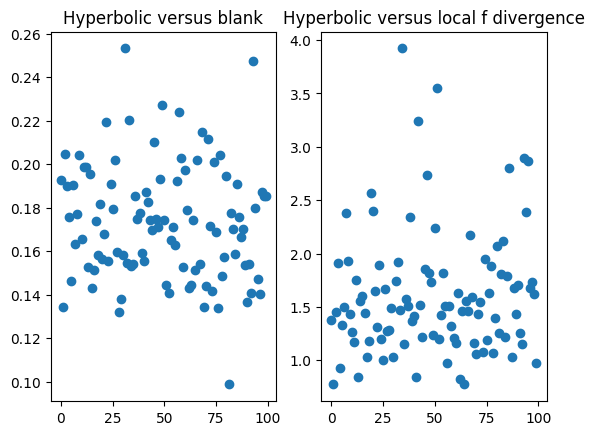

In [14]:
all_raw, all_blk, all_hyper, all_fdiv = test_al_local_disc(n=50, al=.4, n0=9, ntest=100)
# print(np.min(all_blk - all_hyper))
print(np.mean(1-all_hyper/all_blk), np.mean(1-all_hyper/all_fdiv))
print(np.min(1-all_hyper/all_blk), np.min(1-all_hyper/all_fdiv))
fig, axs = plt.subplots(1, 2)
axs[0].scatter(np.arange(all_blk.shape[0]), all_blk- all_hyper)
axs[1].scatter(np.arange(all_blk.shape[0]), all_fdiv- all_hyper)
# plt.scatter(np.arange(all_hyper.shape[0]), all_hyper)
axs[0].set_title("Hyperbolic versus blank")
axs[1].set_title("Hyperbolic versus local f divergence")